# Brillouin Zone Integration on a Photonic Crystal II

This tutorial is based on the example of a gaussian beam incident upon a photonic crystal in this [script](https://github.com/facebookresearch/fmmax/blob/main/examples/crystal.py).

In [30]:
# Permittivity of the region above and below the slab, and of the holes in the slab.
permittivity_ambient = (1.0 + 0.0j) ** 2
# Permittivity of the slab.
permittivity_slab = (1.5 + 0.0j) ** 2
# Thickness of the ambient layers above and below the slab.
thickness_ambient = 2.0
# Thickness of the photonic crystal slab.
thickness_slab = 0.8
# The unit cell pitch.
pitch = 1.0
# The diameter of the holes in the photonic crystal.
diameter = 0.7
# The size of a pixel in permittivity arrays.
resolution = 0.01
# The size of a pixel in field arrays.
resolution_fields = 0.05
# The wavelength of the dipole emission.
wavelength = 0.63
# The number of terms in the Fourier expansion.
approximate_num_terms = 50
# The shape of the grid used for Brillouin zone integration.
brillouin_grid_shape = (9, 9)

# Scenario 1: Aperiodic dipole source inside a photonic crystal slab.

## Setting up the simulation

First, we calculate the basis expansion with circular truncation. 

In [12]:
from jax import numpy as jnp
from fmmax import basis

primitive_lattice_vectors = basis.LatticeVectors(u=pitch * basis.X, v=pitch * basis.Y)
expansion = basis.generate_expansion(
    primitive_lattice_vectors=primitive_lattice_vectors,
    approximate_num_terms=approximate_num_terms,
    truncation=basis.Truncation.CIRCULAR,
)

In our simulation of aperiodic dipole sources, it's crucial to define the Bloch phase. This phase establishes a relationship between the two sides of the primitive unit cell. For this purpose, we can conveniently utilize the `basis.brillouin_zone_in_plane_wavevector()` function. This function generates the Bloch phase (referred to as `in_plane_wavevector`) based on the shape of the Brillouin zone grid (M x N) and the lattice vectors of the primitive unit cell. This function returns M x N wavevectors.

In [13]:
import functools
from fmmax import fmm, basis

# Brillouin zone integration creates a batch of in-plane wavevectors which are
# distributed throughout the first Brillouin zone.
in_plane_wavevector = basis.brillouin_zone_in_plane_wavevector(
    brillouin_grid_shape, primitive_lattice_vectors
)
# check the shape of in_plane_wavevector, should be (M, N, 2)
print(in_plane_wavevector.shape)

(9, 9, 2)


Since we will be using the same parameters to solve for eigenmodes inside our Brillouin Zone, we can once again compose a partial function for the ease of reuse.

In [14]:
eigensolve = functools.partial(
    fmm.eigensolve_isotropic_media,
    wavelength=jnp.asarray(wavelength),
    in_plane_wavevector=in_plane_wavevector,
    primitive_lattice_vectors=primitive_lattice_vectors,
    expansion=expansion,
    formulation=fmm.Formulation.FFT,
)

Here, we construct a function called `unit_cell_pattern()` that generates the permittivity distribution in the xy directions. Let's also visualize it.

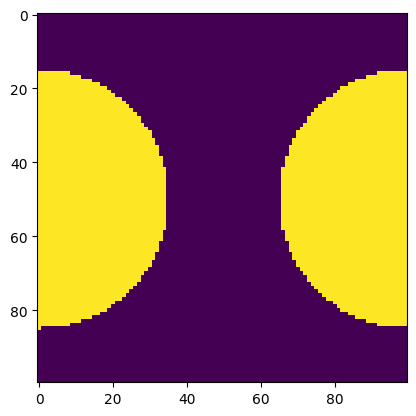

In [15]:
import jax.numpy as jnp
import matplotlib.pyplot as plt  # type: ignore[import]


def unit_cell_pattern(
    pitch: float,
    diameter: float,
    resolution: float,
) -> jnp.ndarray:
    """Defines the pattern of the photonic crystal."""
    x, y = jnp.meshgrid(
        jnp.arange(0, pitch, resolution),
        jnp.arange(0, pitch, resolution),
        indexing="ij",
    )
    return (jnp.sqrt((x - pitch / 2) ** 2 + y**2) < diameter / 2) | (
        jnp.sqrt((x - pitch / 2) ** 2 + (y - pitch) ** 2) < diameter / 2
    )


# Try plotting a unit cell.
mask = unit_cell_pattern(pitch, diameter, resolution)

plt.imshow(mask)
plt.show()

Now, we can solve for the eigemodes in the crystal as well as the ambient regions.

In [16]:
permittivity_crystal = jnp.where(mask, permittivity_ambient, permittivity_slab)
solve_result_crystal = eigensolve(permittivity=permittivity_crystal)
solve_result_ambient = eigensolve(
    permittivity=jnp.asarray(permittivity_ambient)[jnp.newaxis, jnp.newaxis]
)

To model a dipole inside the photonic crystal we must break the stack into two, and compute scattering matrices for the stacks above and below the plane containing the dipole. Since we want to visualize fields, we also need the interior scattering matrices.

In [17]:
from typing import Tuple


def crystal_cross_sections(
    thickness_ambient: float,
    thickness_slab: float,
    pitch: float,
    diameter: float,
    resolution: float,
    num_unit_cells: Tuple[int, int],
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Computes cross sections of the photonic crystal structure."""
    mask = unit_cell_pattern(pitch, diameter, resolution)

    xy_section = jnp.tile(mask, num_unit_cells)

    xz_slab = mask[:, 0]
    xz_section = jnp.stack(
        (
            [jnp.ones_like(xz_slab)] * int(thickness_ambient / resolution)
            + [xz_slab] * int(thickness_slab / resolution)
            + [jnp.ones_like(xz_slab)] * int(thickness_ambient / resolution)
        ),
        axis=-1,
    )
    xz_section = jnp.tile(xz_section, (num_unit_cells[0], 1))

    yz_slab = mask[0, :]
    yz_section = jnp.stack(
        (
            [jnp.ones_like(yz_slab)] * int(thickness_ambient / resolution)
            + [yz_slab] * int(thickness_slab / resolution)
            + [jnp.ones_like(yz_slab)] * int(thickness_ambient / resolution)
        ),
        axis=-1,
    )
    yz_section = jnp.tile(yz_section, (num_unit_cells[1], 1))

    return xy_section, xz_section, yz_section

# Scenario 2: Gaussian beam incident on photonic crystal slab

# Setting up the simulation

In this scenario, we use a gaussian beam to excite the same photonic crystal. We also use 3 wavelengths in the simulation to emulate a broadband source.

To generalize the Gaussian beam, we parameterize the polar, azimuthal, and polarization angles.

In [18]:
# The wavelengths, of the gaussian beam
wavelengths = jnp.asarray([0.62, 0.63, 0.64])
# The polar angle of the incident beam.
polar_angle: float = 0.15 * jnp.pi
# The azimuthal angle of the incident beam.
azimuthal_angle: float = 0.0
# The angle giving the polarization rotation about the propagation axis.
polarization_angle: float = 0.0
# The Gaussian beam waist.
beam_waist: float = 1.0
# The offset of the Gaussian beam focus from the top of the photonic crystal slab.
beam_focus_offset: float = 0.0

Brillouin zone integration creates a batch of in-plane wavevectors which are distributed throughout the first Brillouin zone. We shift the expansion so that it is centered on the direction of the incident beam. Notice now we have an extra dimension to batch in the different wavelengths.

In [19]:
in_plane_wavevector = basis.brillouin_zone_in_plane_wavevector(
    brillouin_grid_shape, primitive_lattice_vectors
)
wavelengths = jnp.expand_dims(jnp.atleast_1d(wavelengths), axis=(1, 2))
in_plane_wavevector += basis.plane_wave_in_plane_wavevector(
    wavelength=jnp.asarray(wavelengths),
    polar_angle=jnp.asarray(polar_angle),
    azimuthal_angle=jnp.asarray(azimuthal_angle),
    permittivity=jnp.asarray(permittivity_ambient),
)

in_plane_wavevector.shape

(3, 9, 9, 2)

Once again, we compose a partial function with immutable parameters, and solve for the eigenmodes in the photonic crystal and the ambient regions. Then, we compute the interior S-matrices.

In [20]:
from fmmax import scattering

eigensolve = functools.partial(
    fmm.eigensolve_isotropic_media,
    wavelength=jnp.asarray(wavelengths),
    in_plane_wavevector=in_plane_wavevector,
    primitive_lattice_vectors=primitive_lattice_vectors,
    expansion=expansion,
    formulation=fmm.Formulation.FFT,
)

mask = unit_cell_pattern(pitch, diameter, resolution)
permittivity_crystal = jnp.where(mask, permittivity_ambient, permittivity_slab)
solve_result_crystal = eigensolve(permittivity=permittivity_crystal)
solve_result_ambient = eigensolve(
    permittivity=jnp.asarray(permittivity_ambient)[jnp.newaxis, jnp.newaxis]
)

s_matrices_interior = scattering.stack_s_matrices_interior(
    layer_solve_results=[
        solve_result_ambient,
        solve_result_crystal,
        solve_result_ambient,
    ],
    layer_thicknesses=[thickness_ambient, thickness_slab, thickness_ambient],
)

The following snippet is a function that maps the real-space (Cartesian) location to the corresponding EM fields of a Gaussian beam. Note that it has wavelengths batched in.

In [21]:
def _paraxial_gaussian_field_fn(x, y, z):
    # Returns the fields of a z-propagating, x-polarized Gaussian beam.
    # See https://en.wikipedia.org/wiki/Gaussian_beam

    # Adjust array dimensions for proper batching
    wavelengths_padded = wavelengths[..., jnp.newaxis, jnp.newaxis]

    k = 2 * jnp.pi / wavelengths_padded
    z_r = jnp.pi * beam_waist**2 * jnp.sqrt(permittivity_ambient) / wavelengths_padded
    w_z = beam_waist * jnp.sqrt(1 + (z / z_r) ** 2)
    r = jnp.sqrt(x**2 + y**2)
    ex = (
        beam_waist
        / w_z
        * jnp.exp(-(r**2) / w_z**2)
        * jnp.exp(
            1j
            * (
                (k * z)  # Phase
                + k * r**2 / 2 * z / (z**2 + z_r**2)  # Wavefront curvature
                - jnp.arctan(z / z_r)  # Gouy phase
            )
        )
    )
    ey = jnp.zeros_like(ex)
    ez = jnp.zeros_like(ex)
    hx = jnp.zeros_like(ex)
    hy = ex / jnp.sqrt(permittivity_ambient)
    hz = jnp.zeros_like(ex)
    return (ex, ey, ez), (hx, hy, hz)

With the normal incidence parameterized, we can now rotate the Gaussian beam to our desired orientation and polarization state using a convenient function `beams.shifted_rotated_fields()`. We do need the real-space coordinates of the supercell which can be obtained using the `basis.unit_cell_coordinates()` function. Let's also visualize the rotated field.

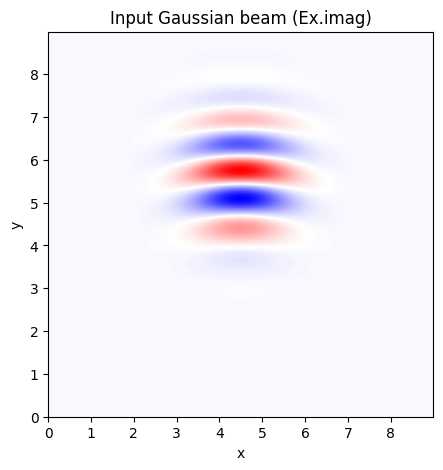

In [ ]:
from fmmax import beams

# Solve for the fields of the beam with the desired rotation and shift.
x, y = basis.unit_cell_coordinates(
    primitive_lattice_vectors=primitive_lattice_vectors,
    shape=permittivity_crystal.shape[-2:],  # type: ignore[arg-type]
    num_unit_cells=brillouin_grid_shape,
)
(beam_ex, beam_ey, _), (beam_hx, beam_hy, _) = beams.shifted_rotated_fields(
    field_fn=_paraxial_gaussian_field_fn,
    x=x,
    y=y,
    z=jnp.zeros_like(x),
    beam_origin_x=jnp.amax(x) / 2,
    beam_origin_y=jnp.amax(y) / 2,
    beam_origin_z=thickness_ambient - beam_focus_offset,
    polar_angle=jnp.asarray(polar_angle),
    azimuthal_angle=jnp.asarray(azimuthal_angle),
    polarization_angle=jnp.asarray(polarization_angle),
)

# Plot the beam.
plt.figure(figsize=(5, 5))
plt.title("Input Gaussian beam (Ex.imag)")
extent = (x.min(), x.max(), y.min(), y.max())
plt.xlabel("x")
plt.ylabel("y")
plt.imshow(beam_ex[0, 0, 0, ...].imag, cmap="bwr", extent=extent)
plt.show()

Notice that we have the excitation field in real-space coordinates. To use it in FMM, we must transform it into Fourier domain, given the shape of our supercell. We can use `sources.amplitudes_for_fields()` for this task. Just remember to pass in the eigensolve result of the layer that contains the field as well as the the dimension indices of the Brillouin Zone grid. Since we have a wavelength dim at 0, our M and N dims are 1 and 2.

In [23]:
# from fmmax import sources

# brillouin_grid_axes = (1, 2)
# # Add an additional axis for the number of sources
# fwd_amplitude, _ = sources.amplitudes_for_fields(
#     ex=beam_ex[..., jnp.newaxis],
#     ey=beam_ey[..., jnp.newaxis],
#     hx=beam_hx[..., jnp.newaxis],
#     hy=beam_hy[..., jnp.newaxis],
#     layer_solve_result=solve_result_ambient,
#     brillouin_grid_axes=brillouin_grid_axes,
# )

With the Fourier amplitudes of the fields computed, we can finally calculate the amplitudes inside each layer.

In [24]:
# from fmmax import fields

# # Compute the fields inside the structure.
# amplitudes_interior = fields.stack_amplitudes_interior(
#     s_matrices_interior=s_matrices_interior,
#     forward_amplitude_0_start=fwd_amplitude,
#     backward_amplitude_N_end=jnp.zeros_like(fwd_amplitude),
# )

## Brillouin Zone Integration and Visualization 

With that, let's begin the postprocessing steps to convert back to the real-space for visualization.

In [25]:
# # Coordinates where fields are to be evaluated.
# x = jnp.arange(0, pitch * brillouin_grid_shape[0], resolution_fields)
# y = jnp.ones_like(x) * pitch * brillouin_grid_shape[1] / 2
# (ex, ey, ez), (hx, hy, hz), (x, y, z) = fields.stack_fields_3d_on_coordinates(
#     amplitudes_interior=amplitudes_interior,
#     layer_solve_results=[
#         solve_result_ambient,
#         solve_result_crystal,
#         solve_result_ambient,
#     ],
#     layer_thicknesses=[
#         thickness_ambient,
#         thickness_slab,
#         thickness_ambient,
#     ],
#     layer_znum=[
#         int(thickness_ambient / resolution_fields),
#         int(thickness_slab / resolution_fields),
#         int(thickness_ambient / resolution_fields),
#     ],
#     x=x,
#     y=y,
# )

Just like before, we can now perform the Brillouin zone integration by averaging over the Brillouin zone grid batch axes.

In [26]:
# ex, ey, ez, hx, hy, hz = [
#     jnp.mean(field, axis=brillouin_grid_axes) for field in (ex, ey, ez, hx, hy, hz)
# ]

Finally, we visualize the BZ averaged fields for each wavelength.

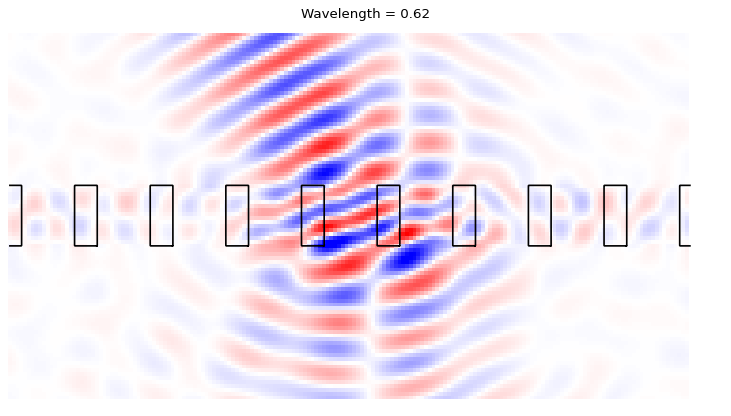

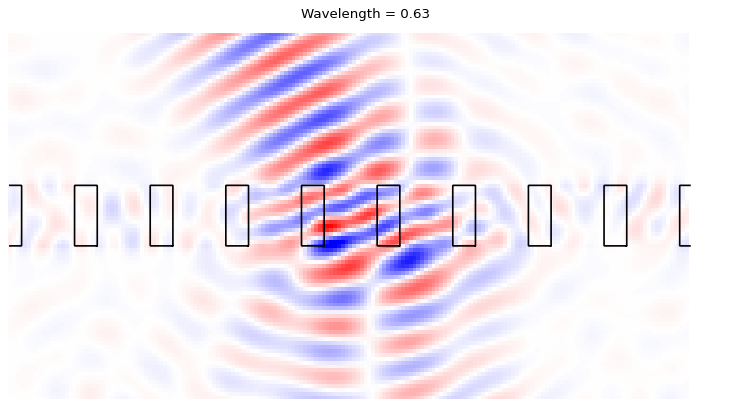

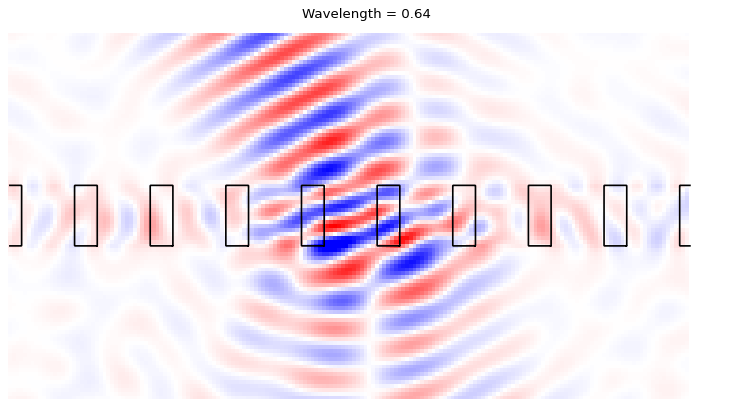

In [29]:
# import numpy as onp
# from skimage import measure

# # Compute some cross sections for visualizing the structure.
# section_xy, section_xz, section_yz = crystal_cross_sections(
#     thickness_ambient=float(thickness_ambient),
#     thickness_slab=float(thickness_slab),
#     pitch=pitch,
#     diameter=diameter,
#     resolution=resolution,
#     num_unit_cells=brillouin_grid_shape,
# )

# for wavelength_idx in range(3):
#     xplot, zplot = jnp.meshgrid(x, z, indexing="ij")
#     field_plot = ex[wavelength_idx, :, :, 0].real

#     plt.figure(figsize=(float(jnp.amax(xplot)), float(jnp.amax(zplot))), dpi=80)
#     plt.title("Wavelength = " + str(wavelengths[wavelength_idx, 0, 0]))
#     ax = plt.subplot(111)
#     im = plt.pcolormesh(xplot, zplot, field_plot, shading="nearest", cmap="bwr")

#     im.set_clim((-float(jnp.amax(field_plot)), float(jnp.amax(field_plot))))

#     contours = measure.find_contours(onp.array(section_xz))
#     scale_factor = pitch / resolution
#     for c in contours:
#         ax.plot(c[:, 0] / scale_factor, c[:, 1] / scale_factor, "k")

#     ax.axis("equal")
#     ax.axis("off")
#     ax.set_ylim(ax.get_ylim()[::-1])

#     plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
#     plt.show()

We can clearly see a Gaussian beam with an incidence angle of 15°. The photonic crystal clearly modulates he incident Gaussian. We also observe some transversely coupled fields in the photonic crystal.